Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [4]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
#%matplotlib qt 
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [5]:
model_name = 'psm'
#model_name = 'psm_simplified'

model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction 

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

dh = []
springs = []
friction_type = []

if (model_name == 'psm_simplified'):
    # define paralelogram coordinate relation
    # qd -> coordinate for dvrk_ros package
    # qmd -> coordinate for the modeling joints
    # q -> coordinate for motors
    qmd5 = 1.0186 * q5
    qmd6 = -0.8306 * q5 + 1.2178 * q6
    qmd7 = -0.8306 *q5 + 1.2178 * q7
    
    l_2L1 = 96*0.001
    l_2L2 = 516*0.001
    l_2L3 = 40.09*0.001
    
    l_2H1 = 144.54*0.001
    l_2H2 = 38.08*0.001
    
    l_3 = 40.09*0.001
    
    l_RCC = 431.8*0.001
    l_tool = 416.2*0.001
    l_p2y = 9.1*0.001
    
    M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
    M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
    
    L_b = 0
    L_1 = 1
    L_20 = 2
    L_21 = 3
    L_22 = 4
#     L_23 = 5
    L_24 = 5
#     L_25 = 6
    L_30 = 6
    L_31 = 7
    L_4 = 8
    L_5 = 9
    L_6 = 10
    L_7 = 11
    M_6 = 12
    M_7 = 13
    F_67 = 14
    
    # define spring delta L
    dlN = None

    dl4 = -q4
    
    
    x = [None]*15
    x[0]  = (L_b,  -1,   [L_1, M_6, M_7, F_67], 0,           0,      0,              0,          False, False, False, dlN) # Base
    
    x[1]  = (L_1,  L_b,  [L_20],                0,           _pi/2,  0,              q1+_pi/2,   True,  False, True,  dlN) # Yaw
    x[2]  = (L_20, L_1,  [L_21, L_31],          0,           -_pi/2, 0,              q2-_pi/2,   True,  False, True) # -- Intermediate
    x[3]  = (L_21, L_20, [L_22],                l_2L3,       0,      0,              _pi/2,      False, False, False, dlN) # Pitch Back
    x[4]  = (L_22, L_21, [L_24, L_30],          l_2H1,       0,      0,              -q2+_pi/2,  True,  False, False, dlN) # Pitch Front                                    )
    #x[5]  = (L_23, L_21, [],                    l_2H1+l_2H2, 0,      0,              -q2+_pi/2, True,  False, False, dlN)    # Intermediate
    x[5]  = (L_24, L_22, [L_30],                l_2L2,       0,      0,              q2,         True,  False, False, dlN)    # Pitch Bottom
    #x[7]  = (L_25, L_22, [],                    l_2L1,       0,      0,              q2+_pi,    True,  False, False, dlN)    # Pitch Top
    x[6]  = (L_30, L_24, [L_4],                 l_3,         -_pi/2, q3-l_RCC+l_2H1, 0,          True,  False, True,  dlN)    # Pitch End
    x[7]  = (L_31, L_20, [],                    l_2L3,       -_pi/2, q3,             0,          True,  False, False, dlN)    # Main Insertion
    x[8] = (L_4,  L_30, [L_5],                  0,           0,      l_tool,         q4,         False, True,  True,  dl4) # Intermediate Counterweight
    x[9] = (L_5,  L_4,  [L_6, L_7],             0,           _pi/2,  0,              qmd5+_pi/2, False, True,  True,  dlN) # Counterweight
    x[10] = (L_6,  L_5,  [],                    l_p2y,       -_pi/2, 0,              qmd6+_pi/2, False, False, True,  dlN) # Tool Roll 
    x[11] = (L_7,  L_5,  [],                    l_p2y,       -_pi/2, 0,              qmd7+_pi/2, False, False, True,  dlN) # Tool Pitch
    
    x[12] = (M_6,  L_b,  [],                    0,           0,      0,              q6,         False, True,  True,  dlN) # Tool Yaw1 inert
    x[13] = (M_7,  L_b,  [],                    0,           0,      0,              q7,         False, True,  True,  dlN) # Tool Yaw2 inert
    x[14] = (F_67, L_b,  [],                    0,           0,      0,              qmd7-qmd6,  False, False, True,  dlN) # q6 q7 coupled friction
    
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
elif (model_name == 'psm'):
    # define paralelogram coordinate relation
    # qd -> coordinate for dvrk_ros package
    # qmd -> coordinate for the modeling joints
    # q -> coordinate for motors
    qmd5 = 1.0186 * q5
    qmd6 = -0.8306 * q5 + 1.2178 * q6
    qmd7 = -0.8306 *q5 + 1.2178 * q7
    
    l_2L1 = 96*0.001
    l_2L2 = 516*0.001
    l_2L3 = 40.09*0.001
    
    l_2H1 = 144.54*0.001
    l_2H2 = 38.08*0.001
    
    l_3 = 40.09*0.001
    
    l_RCC = 431.8*0.001
    l_tool = 416.2*0.001
    l_p2y = 9.1*0.001
    
    M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
    M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
    
    # define link number
    L_b = 0
    L_1 = 1
    L_20 = 2
    L_21 = 3
    L_22 = 4
    L_23 = 5
    L_24 = 6
    L_25 = 7
    L_30 = 8
    L_31 = 9
    L_4 = 10
    L_5 = 11
    L_6 = 12
    L_7 = 13
    M_6 = 14
    M_7 = 15
    F_67 = 16
    
    # define spring delta L
    dlN = None

    dl10 = -q4
    
    x = [None]*17
    x[0]  = (L_b,  -1,   [L_1, M_6, M_7, F_67], 0,           0,      0,              0,          False, False, False, dlN) # Base
    
    
    x[1]  = (L_1,  L_b,  [L_20],                0,           _pi/2,  0,              q1+_pi/2,   True,  False, True,  dlN) # Yaw
    x[2]  = (L_20, L_1,  [L_21, L_31],          0,           -_pi/2, 0,              q2-_pi/2,   True,  False, True,  dlN) # -- Intermediate
    x[3]  = (L_21, L_20, [L_22, L_23],          l_2L3,       0,      0,              _pi/2,      False, False, False, dlN) # Pitch Back
    x[4]  = (L_22, L_21, [L_24, L_25, L_30],    l_2H1,       0,      0,              -q2+_pi/2,  True,  False, False, dlN) # Pitch Front                                    )
    x[5]  = (L_23, L_21, [],                    l_2H1+l_2H2, 0,      0,              -q2+_pi/2,  True,  False, False, dlN)    # Intermediate
    x[6]  = (L_24, L_22, [L_30],                l_2L2,       0,      0,              q2,         True,  False, False, dlN)    # Pitch Bottom
    x[7]  = (L_25, L_22, [],                    l_2L1,       0,      0,              q2+_pi,     True,  False, False, dlN)    # Pitch Top
    x[8]  = (L_30, L_24, [L_4],                 l_3,         -_pi/2, q3-l_RCC+l_2H1, 0,          True,  False, True,  dlN)    # Pitch End
    x[9]  = (L_31, L_20, [],                    l_2L3,       -_pi/2, q3,             0,          True,  False, False, dlN)    # Main Insertion
    x[10] = (L_4,  L_30, [L_5],                 0,           0,      l_tool,         q4,         False, True,  True,  dl10) # Intermediate Counterweight
    x[11] = (L_5,  L_4,  [L_6, L_7],            0,           _pi/2,  0,              qmd5+_pi/2, False, True,  True,  dlN) # Counterweight
    x[12] = (L_6,  L_5,  [],                    l_p2y,       -_pi/2, 0,              qmd6+_pi/2, False, False, True,  dlN) # Tool Roll 
    x[13] = (L_7,  L_5,  [],                    l_p2y,       -_pi/2, 0,              qmd7+_pi/2, False, False, True,  dlN) # Tool Pitch
    
    x[14] = (M_6,  L_b,  [],                    0,           0,      0,              q6,         False, True,  True,  dlN) # Tool Yaw1 inert
    x[15] = (M_7,  L_b,  [],                    0,           0,      0,              q7,         False, True,  True,  dlN) # Tool Yaw2 inert
    x[16] = (F_67, L_b,  [],                    0,           0,      0,              qmd7-qmd6,  False, False, True,  dlN) # q6 q7 coupled friction
    
    dh = x
    friction_type = ['Coulomb', 'viscous', 'offset']
    print(model_name)
else:
    raise Exception("No robot name matches " + name)
print(friction_type)
robot_def = RobotDef(dh, dh_convention='mdh', friction_type=friction_type)

psm
['Coulomb', 'viscous', 'offset']


In [31]:
M_motor2dvrk_q = np.matrix([[1.0186, 0, 0], [-0.8306, 0.6089, 0.6089], [0, -1.2177, 1.2177]])
M_model2dvrk_q = np.matrix([[1, 0, 0], [0, 0.5, 0.5], [0, -1, 1]])
M_motor2model_q = np.linalg.inv(M_model2dvrk_q)*M_motor2dvrk_q
M_motor2model_q[np.abs(M_motor2model_q) < 0.0001] = 0
M_motor2model_q

matrix([[ 1.0186 ,  0.     ,  0.     ],
        [-0.8306 ,  1.21775,  0.     ],
        [-0.8306 ,  0.     ,  1.21775]])

In [32]:
robot_def.coordinates_joint_type

['R', 'R', 'P', 'R', 'R', 'R', 'R']

In [33]:
robot_def.bary_params

## Create kinematics chain

In [34]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
Frame: 10
Frame: 11
Frame: 12
Frame: 13
Frame: 14
Frame: 15
Frame: 16
CPU times: user 11min 59s, sys: 1.58 s, total: 12min
Wall time: 11min 58s


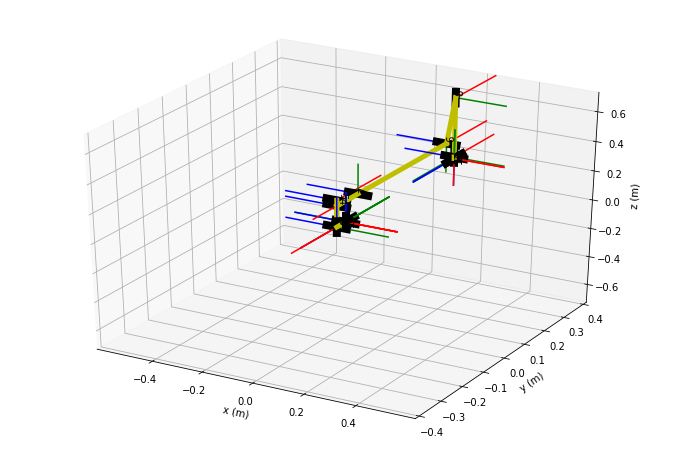

In [15]:
angle = [0, 0.0, 0, 0, 0, 0, 0]
geom.draw_geom(angle)

## Create dynamics

In [16]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/16
Calculating the link kinetic energy of 2/16
Calculating the link kinetic energy of 4/16
Calculating the link kinetic energy of 5/16
Calculating the link kinetic energy of 6/16
Calculating the link kinetic energy of 7/16
Calculating the link kinetic energy of 8/16
Calculating the link kinetic energy of 9/16
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
tau of q7
Adding frictions and springs...
Add motor inertia...
Calculating regressor...
Calculating M, C and G...
Calculating base parameter...
base parameter number: 49
Creating H_b function...
Finished creating robot dynamics
CPU times: user 28.3 s, sys: 907 ms, total: 29.2 s
Wall time: 26.6 s


In [11]:
sympy.Matrix(dyn.base_param)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [12]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 49 parameters


---
# 3 - Excitation trajectory optimization

In [17]:
model_name = 'psm_simplified'
#model_name = 'psm'

Load Data

In [18]:
from utils import load_data
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [19]:
#trajectory_name = 'one'
#trajectory_name = 'three'
trajectory_name = 'four'

In [20]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.18
fourier_order = 6

joint_constraints = []
cartesian_constraints = []

if model_name == 'psm_simplified':
    q_dvrk7 = 1.2177*q7 - 1.2177*q6
#     q_mod6 = (4871*q6)/4000 - (4153*q5)/5000
#     q_mod7 = - (4153*q5)/5000 + (4871*q7)/4000
    
    q_dvrk5 = 1.0186 * q5
    q_mod6 = -0.8306 * q5 + 1.2178 * q6
    q_mod7 = -0.8306 * q5 + 1.2178 * q7
    
    joint_constraints = [(q1, -1.45, 1.45, -1.7, 1.7),
                         (q2, -0.75, 0.8, -1.7, 1.7),
                         (q3,0.07,0.235,-0.35,0.35),
                         (q4,-1.5,1.5,-2,2),
                         (q_dvrk5,-1.4,1.4,-2,2), 
                         (q_dvrk7, 0.15, 3,-3,3),
                         (q_mod7, -1.5, 1.5,-2,2),
                          (q_mod6, -1.5, 1.5,-2,2)]
else:
    raise Exception("No robot name matches " + model_name)
    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 8
cartesian constraint number: 0
constraint number: 32
frames_constrained: []
Condition number: 146.496999163
Condition number: 146.496999162
Condition number: 113.767857606
Condition number: 63.1366036603
Condition number: 66.5803566777
Condition number: 106.330479481
Condition number: 116.605465774
Condition number: 164.372852694
Condition number: 210.544684093
Condition number: 252.752001089
Condition number: 273.498511667
Condition number: 337.099464488
Condition number: 348.792208591
Condition number: 341.736283224
Condition number: 342.54576543
Condition number: 347.384531012
Condition number: 348.233518617
Condition number: 348.577321999
Condition number: 352.492129923
Condition number: 355.501323678
Condition number: 355.949088836
Condition number: 355.899432077
Condition number: 355.855910869
Condition number: 355.830029317
Condition number: 355.447221791
Condition number: 355.353955141
Condition number: 355.305996874
Condition number: 355.299603335
Co

In [21]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [22]:
traj_optimizer.calc_frame_traj()

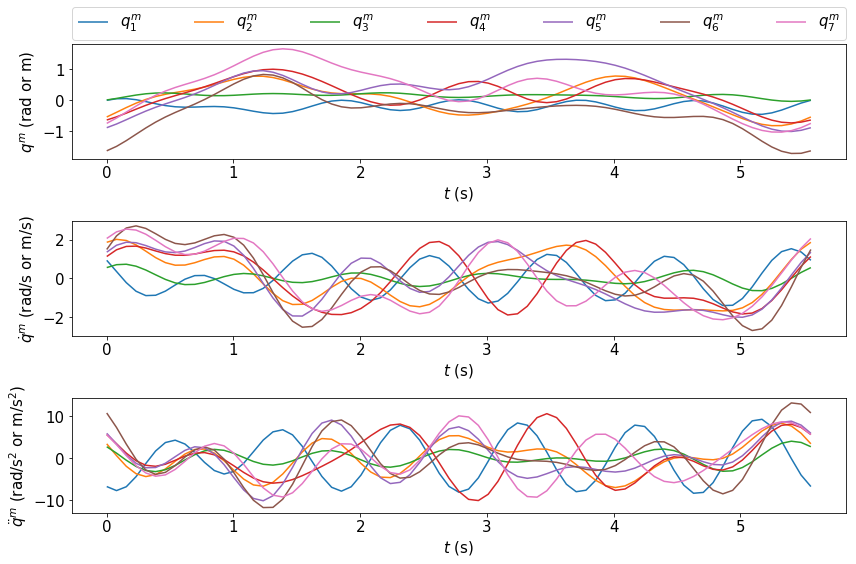

<Figure size 864x576 with 0 Axes>

In [28]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [29]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

In [30]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
q1,-0.1877,-0.0191,0.0107,0.226,0.2893,0.2369,0.1862,0.0109,-0.0813,-0.116,-0.0245,0.1865,-1.0593
q2,0.0864,0.1467,0.47,0.6868,-0.1115,0.233,0.434,0.0722,1.2791,0.0129,-0.0364,-0.1937,0.2359
q3,0.1486,0.0464,0.0323,0.0296,0.0491,0.1968,0.2014,0.0307,0.0485,0.0152,0.218,0.0493,0.1782
q4,0.2258,0.155,0.3255,-0.0803,0.3699,-0.0934,0.4492,0.2419,1.0061,0.9141,-0.7797,0.5985,0.0095
q5,0.3635,-0.1258,0.8912,0.0766,-0.2848,0.4034,0.3895,0.7037,1.1342,0.2914,0.2584,-0.4521,0.4273
q6,-0.3571,0.4269,0.4307,-0.2174,-0.356,0.7692,0.4352,0.4253,1.1555,0.8344,0.3126,0.0576,0.4472
q7,0.3501,0.6519,0.4726,-0.1491,0.5939,0.5882,-0.1018,0.4729,1.3575,0.1049,0.3389,-0.5517,0.4689


---
# Data processing

## Load data

In [6]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

### Load robot model

In [7]:
# Names as Arguments
model_name = 'psm'

training_trajectory_name = 'one'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                          training_trajectory_name)
#dof, fourier_order, base_freq, traj_optimizer_result = load_data(trajectory_folder,training_trajectory_name)
     
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 6
Base frequency: 0.18


### Load traning data set

In [8]:
# training_trajectory_name = 'one'
training_trajectory_name = 'one_205_grams_parallel'
results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 200
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (5999, 21))


### Training trajectory

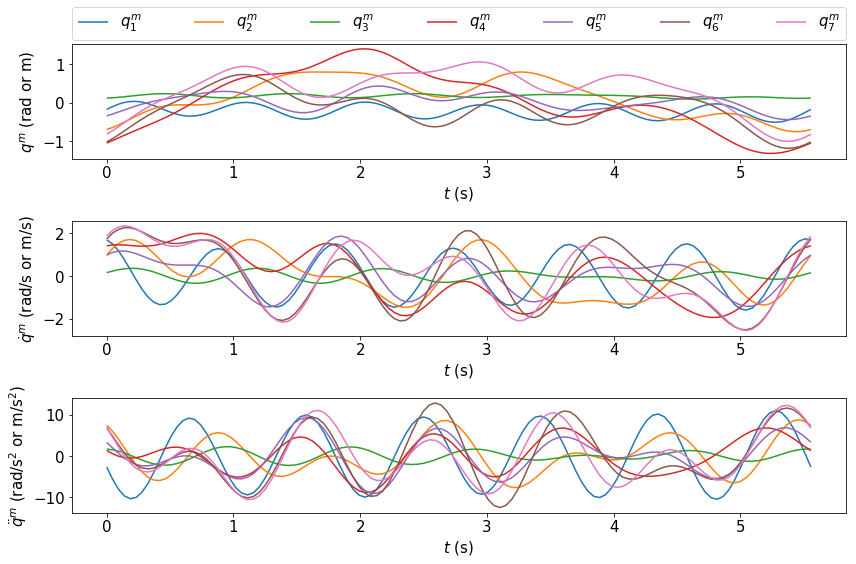

In [9]:
from trajectory_optimization import FourierTraj
fourier_traj_train = FourierTraj(dof, fourier_order, base_freq, sample_num_per_period=20)
traj_plotter_train = TrajPlotter(fourier_traj_train, coordinates=robot_model.coordinates)
traj_plotter_train.plot_desired_traj(traj_optimizer_result)

### Load test data set

In [10]:
test_trajectory_name = 'two'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 200
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                   trajectory_sampling_rate)

(<type 'numpy.ndarray'>, (5999, 21))


## Calculate filter cut-off frequency

In [11]:
# times of the highest frequency in the Fourier series
#fc_mult = 4.0

fc_mult = [5] #(good)
#fc_mult = [8, 8, 5, 3, 4, 4, 4]

#fc_mult = 4
print(base_freq)
fc = np.array(fc_mult)*base_freq* fourier_order 

print(fc)


0.18
[5.4]


## Differentiation and filtering

### Traning data

q_raw shape: (5999, 7)
plot shape: 470


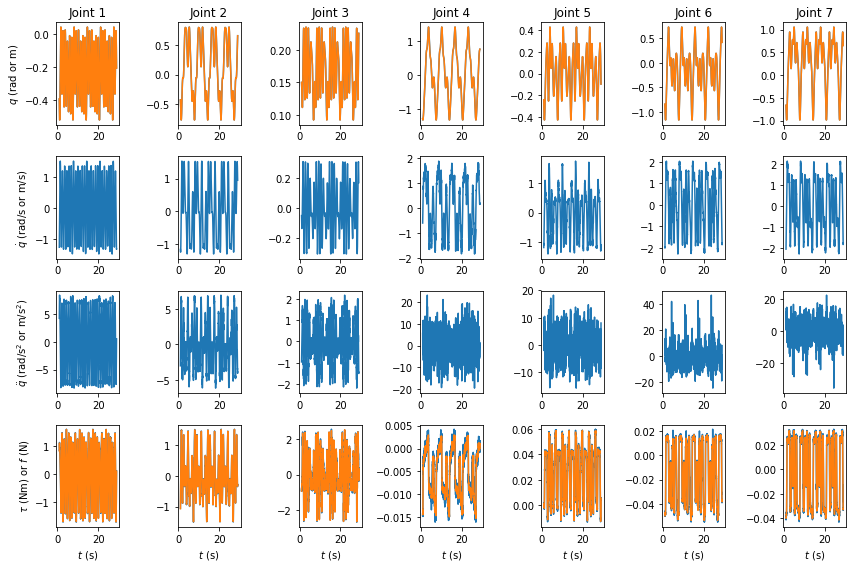

In [12]:
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

### Test data

q_raw shape: (5999, 7)
plot shape: 470


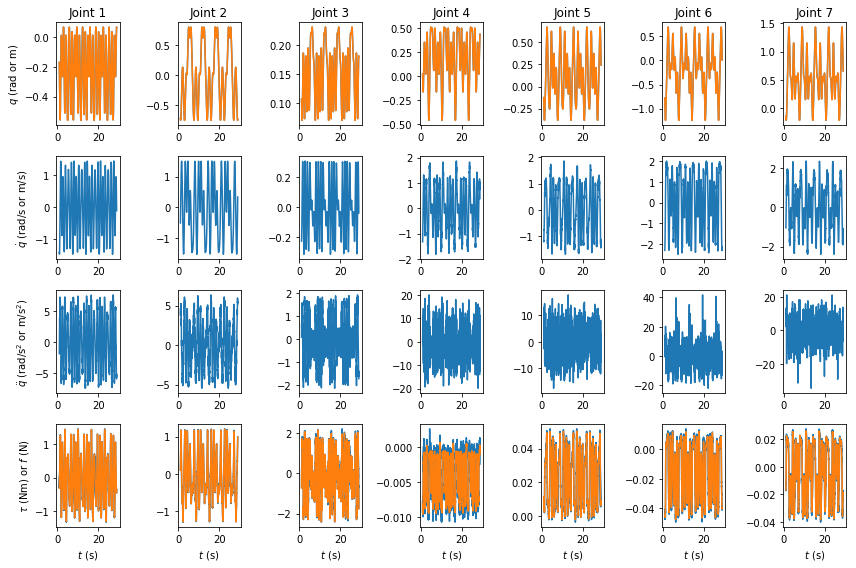

In [13]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [14]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [15]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [16]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [17]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 350
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Base Parameter,Value
1.0*m9,0.3551042525718947
1.0*m8,0.3634819612819592
-0.5*l2y + 0.5*l6y - 0.5*l7y + 1.0*l8z - 0.07227*m4 - 0.09131*m5 - 0.07227*m6 - 0.07227*m7,0.03115683812182772
0.5*l2x - 0.5*l6x + 0.5*l7x + 1.0*l9x + 0.020045*m4 + 0.020045*m5 + 0.020045*m6 + 0.020045*m7,-0.013779329004018903
0.5*l2y - 0.5*l6y + 0.5*l7y + 1.0*l9z + 0.07227*m4 + 0.09131*m5 + 0.07227*m6 + 0.07227*m7,-0.1338722858653396
-0.5*l2x + 0.5*l6x - 0.5*l7x + 1.0*l8x - 0.020045*m4 - 0.020045*m5 - 0.020045*m6 - 0.020045*m7,0.011689229270861495
-0.5*l1y - 0.5*l2z - 0.5*l4z - 0.5*l5z - 0.5*l6z - 0.5*l7z + 1.0*l9y,0.05462666342994024
-0.5*l1y - 0.5*l2z - 0.5*l4z - 0.5*l5z - 0.5*l6z - 0.5*l7z + 1.0*l8y,0.051927081853157
1.0*l5y,-4.719195271094355
1.0*L2xy + 1.0*L6xy + 1.0*L7xy + 1.0*L8xz + 1.0*L9xz + 0.2159*l2x + 0.020045*l2y - 0.07136*l6x + 0.020045*l6y + 0.07136*l7x - 0.020045*l7y + 0.00575813*m4 + 0.00499481*m5 + 0.00575813*m6 + 0.00575813*m7,-0.08361004257795823


## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [18]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]
    

### Evaluate regression

In [19]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.00037586894976494937
standard deviation of xb using OLS:
[3.26421293e-04 2.05330638e-04 1.55402290e-04 1.27209138e-04
 1.65236960e-04 1.11280975e-04 1.28496352e-03 1.28479424e-03
 7.87448318e-02 4.15045266e-04 2.52081230e-04 4.98035438e-04
 5.52961008e-04 8.64755031e-05 5.66184225e-04 3.43442721e-03
 5.22850312e-05 5.34703130e-04 3.83728524e-03 4.56801579e-05
 3.67561232e-05 4.01002646e-05 6.21577879e-04 3.47404009e-04
 1.23154026e-04 2.14789713e-04 6.47032474e-04 6.84366191e-04
 2.45483869e-03 3.02862118e-04 5.38931899e-04 5.81976193e-04
 8.64204616e-03 1.93011247e-04 2.60902286e-04 2.55784421e-02
 1.75058184e-03 2.61908786e-03 4.38477985e-04 4.51327032e-04
 3.58508814e-04 5.24686103e-04 5.30021280e-04 5.44845401e-04
 5.13499009e-04 5.78605531e-04 5.86795271e-04 5.73410265e-04
 8.15132687e-02]
percentage of standard deviation of xb using OLS: 
[9.19226653e-04 5.64899115e-04 4.98774263e-03 9.23188189e-03
 1.23428803e-03 9.51995829e-03 2.3522643

### Plot measured torque and predicted torque

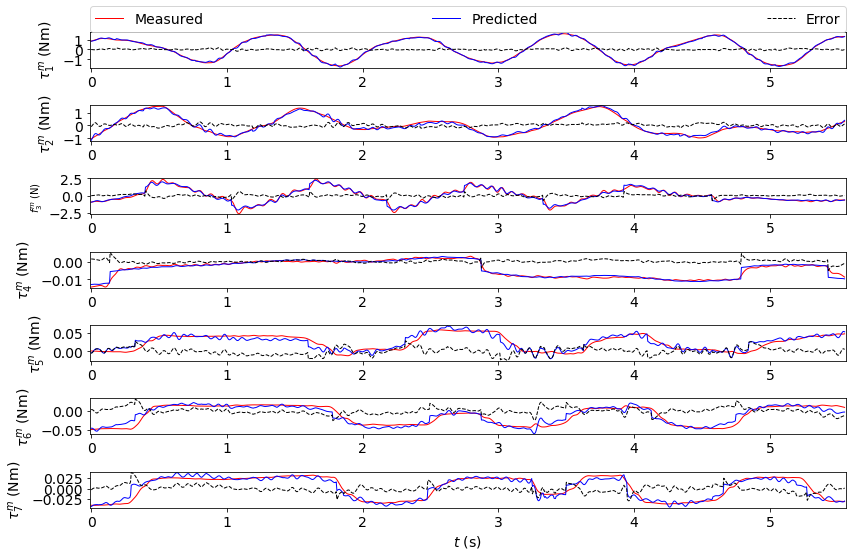

In [20]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [21]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

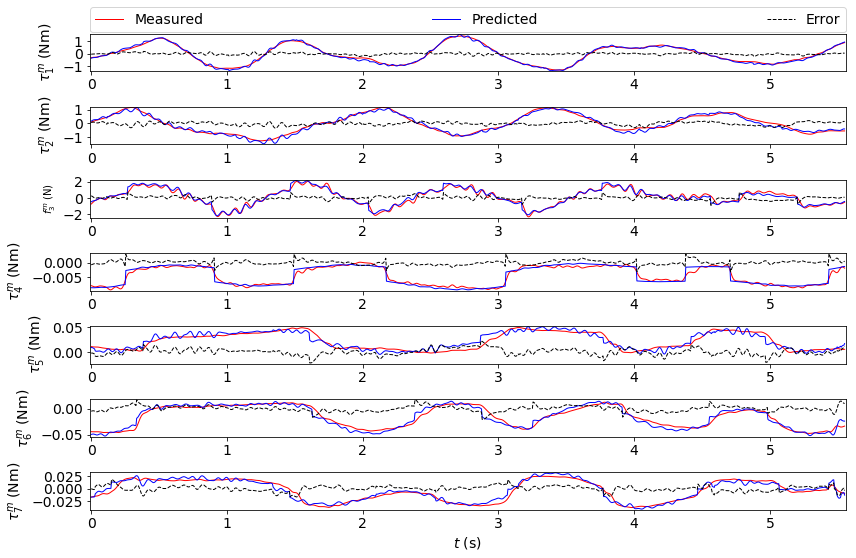

In [22]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [23]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_test[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.10271958, 0.18394008, 0.19826131, 0.13442613, 0.24024134,
       0.21187137, 0.26383741])

## Weighted Least Square (WLS)

### Training data set

In [21]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
weight

array([3.31417659, 3.01119306, 5.21007097, 0.0182707 , 0.0714317 ,
       0.07107427, 0.07324379])

In [22]:
W_b_train.shape, tau_s_train.shape

In [23]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [24]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [25]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [26]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [27]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]

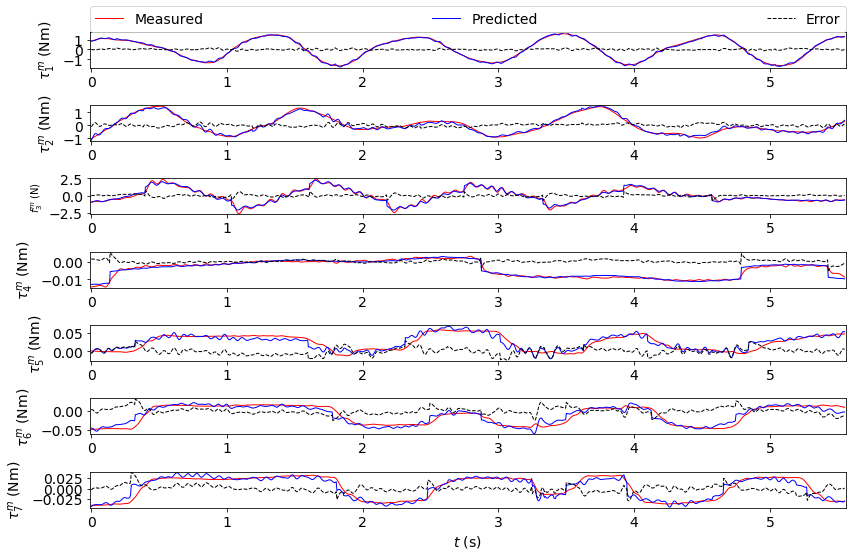

In [28]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_train[:plot_data_num, :],
                   tau_p_wls_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type, 
                   robot_model.coordinates)

In [29]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_wls_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.05888568, 0.14291895, 0.15915677, 0.14077184, 0.2898087 ,
       0.31017552, 0.30592836])

### Test data set

In [30]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)

# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_wls_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

NameError: name 'W_b_test' is not defined

In [31]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_wls_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

NameError: name 'tau_p_wls_test' is not defined

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [32]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [33]:
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

min $m$, max $m$, min $r_x$, max $r_x$, min $r_y$, max $r_y$, min $r_z$, max $r_z$, max $F_c$, max $F_v$, max $F_o$, min $K$, max $K$

In [34]:
sdp_constraints = []
spring_constraints = []

if model_name == 'psm':
    sdp_constraints = [(0.3, 10, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, 0.3, 0.5, 0.3, 0, 0), #yaw_link
                      (0.3, 10, -0.1, 0.1, -0.2, 0.1, -0.05, 0.05, 0.3, 0.5, 0.2, 0, 0),    #Pitch Back
                      (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), #Intermediate
                      (0.1, 5, 0.1, 0.4, -0.06, 0.02, -0.03, 0.03, 0.3, 0.5, 0.2, 0, 0), #Pitch Bottom
                      (0.02, 2, 0.1, 0.4, -0.03, 0.03, -0.03, 0.03, 0.3, 0.5, 0.2, 0, 0), #Pitch Top
                      (0.1, 5, 0.0, 0.05, -0.40, 0.05, -0.03, 0.03, 0.3, 0.5, 0.2, 0, 0), #Pitch End
                      (0.01, 0.5, -0.05, 0.0, -0.14, 0.0, 0.02, 0.08, 0.3, 0.5, 0.2, 0, 0),  #Pitch Front
                      (0.1, 2, -0.02, 0.02, -0.02, 0.02, -0.1, 0.15, 0.6, 2, 0.2, 0, 0), #Main Insertion
                      (0.1, 2, -0.05, 0.05, -0.03, 0.03, -0.1, 0.1, 0.2, 0.5, 0.2, 0, 0), #Counterweight
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0.0001, 1), # Wrist Roll
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0, 0), # Wrist Pitch
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0, 0), # Wrist Yaw1
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0, 0), # Wrist Yaw2
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0, 0), # M6
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0, 0), # M7
                      (0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0, 0)] # F67
else:
    raise Exception("No robot name matches " + model_name)

In [35]:
sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model, sdp_constraints)
%time sdp_opt_std.solve(20000)

Regressor shape: (39193, 115)
Regressand shape: (39193,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 901744, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 20000, normalize = 1, scale = 1.00
Variables n = 116, constraints m = 39406
Cones:	linear vars: 131
	soc vars: 39195, soc blks: 1
	sd vars: 80, sd blks: 8
Setup time: 3.29e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf       inf       inf  8.34e-02 


  9400| 4.31e-02  9.50e-04  5.89e-05  2.58e+02  2.59e+02  4.65e-14  3.53e+02 
  9500| 4.23e-02  8.94e-04  5.67e-05  2.59e+02  2.59e+02  4.69e-14  3.56e+02 
  9600| 4.15e-02  9.26e-04  5.43e-05  2.59e+02  2.59e+02  4.73e-14  3.60e+02 
  9700| 4.08e-02  8.84e-04  5.36e-05  2.59e+02  2.59e+02  4.77e-14  3.63e+02 
  9800| 4.01e-02  8.70e-04  5.36e-05  2.60e+02  2.60e+02  4.80e-14  3.66e+02 
  9900| 3.94e-02  8.63e-04  5.26e-05  2.60e+02  2.60e+02  4.84e-14  3.68e+02 
 10000| 3.87e-02  8.39e-04  5.04e-05  2.60e+02  2.60e+02  2.44e-14  3.71e+02 
 10100| 3.80e-02  8.56e-04  4.89e-05  2.61e+02  2.61e+02  2.45e-14  3.74e+02 
 10200| 3.73e-02  8.09e-04  4.86e-05  2.61e+02  2.61e+02  2.47e-14  3.77e+02 
 10300| 3.67e-02  8.19e-04  4.84e-05  2.61e+02  2.61e+02  2.49e-14  3.79e+02 
 10400| 3.60e-02  7.91e-04  4.70e-05  2.61e+02  2.61e+02  2.51e-14  3.82e+02 
 10500| 3.54e-02  7.98e-04  4.52e-05  2.62e+02  2.62e+02  2.52e-14  3.85e+02 
 10600| 3.47e-02  7.84e-04  4.43e-05  2.62e+02  2.62e+02  2.54e-

 20000| 6.55e-03  1.46e-04  6.89e-06  2.68e+02  2.68e+02  3.33e-14  6.21e+02 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 6.21e+02s
	Lin-sys: avg # CG iterations: 33.11, avg solve time: 3.04e-02s
	Cones: avg projection time: 1.37e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.2410e-07, dist(y, K*) = 1.9903e-09, s'y/|s||y| = -2.2833e-12
|Ax + s - b|_2 / (1 + |b|_2) = 6.5504e-03
|A'y + c|_2 / (1 + |c|_2) = 1.4617e-04
|c'x + b'y| / (1 + |c'x| + |b'y|) = 6.8929e-06
----------------------------------------------------------------------------
c'x = 268.0001, -b'y = 268.0038
CPU times: user 1h 21min 37s, sys: 21.9 s, total: 1h 21min 59s
Wall time: 10min 21s


## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [36]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

In [37]:
np.linalg.norm(tau_f_train[:plot_data_num, :] - tau_p_sdp_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_train[:plot_data_num, :], axis=0)

array([0.05937233, 0.15125584, 0.1611635 , 0.14076543, 0.28940403,
       0.31016751, 0.30644794])

### Plot measured torque and predicted torque

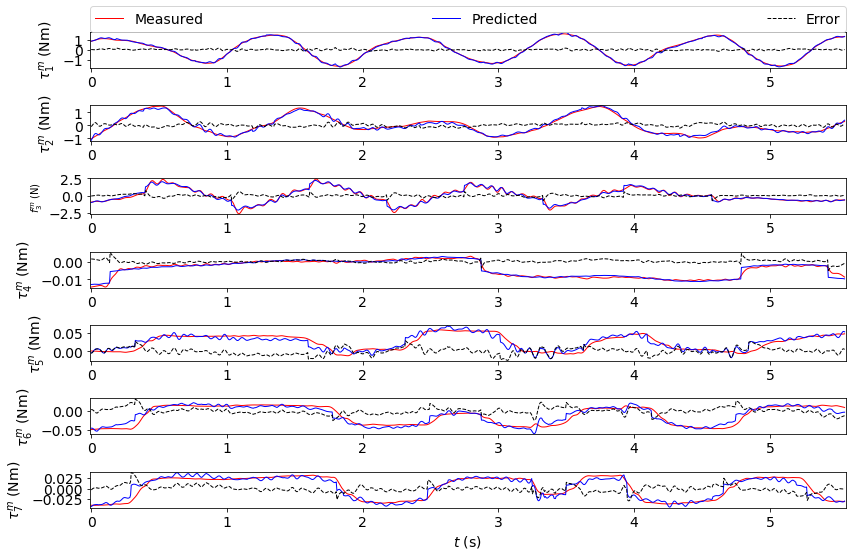

In [38]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_train[:plot_data_num, :],
                   tau_p_sdp_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [92]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

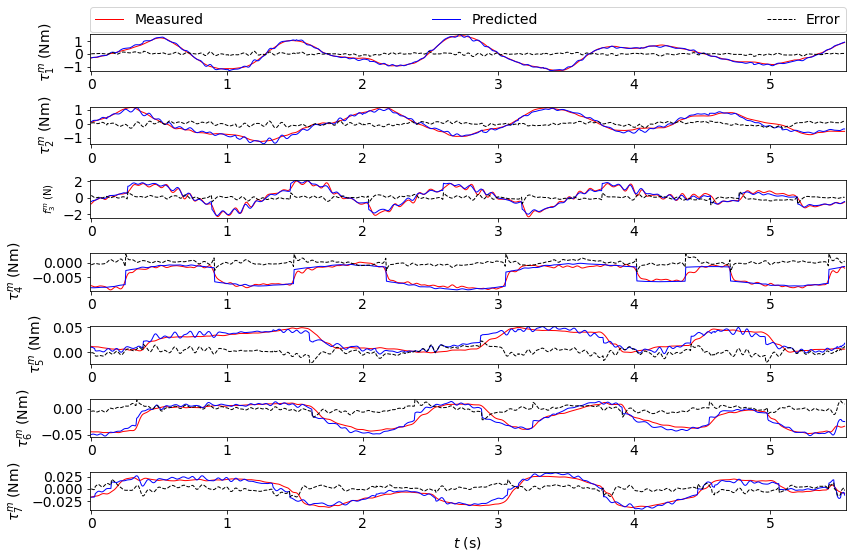

In [93]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [94]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.09289571, 0.17829876, 0.1907355 , 0.13445973, 0.2393902 ,
       0.21251855, 0.26420205])

In [39]:
from identification import params_array2table
x_bary_round= np.around(sdp_opt_std.x_result, decimals=7)
bary_param_table = params_array2table(x_bary_round, robot_model, 'bary')
# sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))
bary_param_table

⎡link     Lₓₓ        L_xy        L_xz        L_yy        L_yz        L_zz     
⎢                                                                             
⎢ 1    1.0659392   5.75e-5       0.0      1.0666788      0.0      0.0007702   
⎢                                                                             
⎢ 2    0.0729429  -0.0149538  0.0067129   0.0287938   -0.0040243  0.0588282   
⎢                                                                             
⎢ 3        0          0           0           0           0           0       
⎢                                                                             
⎢ 4    0.0014865  -0.0077857  -0.0053258  93.3882663  -0.0006826  93.388796   
⎢                                                                             
⎢ 5    0.0017546  0.0048991   -0.004899   37.7679735  0.0008663   37.7679735  
⎢                                                                             
⎢ 6    0.0003442    9.2e-6     1.96e-5    0.0001253 

### Base parameters

In [40]:
robot_model.base_param[0,0]
subs_x_result2bary = [(sym, x) for sym, x in zip(robot_model.bary_param, sdp_opt_std.x_result)]

sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(sympy.Matrix(robot_model.base_param).subs(subs_x_result2bary)))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [41]:
from identification import barycentric2standard_params

In [42]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)
s_round_std = np.round(np.array(x_std).astype(np.float), decimals=7)

In [43]:
std_param_table = params_array2table(s_round_std, robot_model, 'std')
#sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))
std_param_table

⎡link     Iₓₓ        I_xy       I_xz        I_yy       I_yz        I_zz       
⎢                                                                             
⎢ 1    1.0659348     0.0         0.0     1.0659351      0.0      2.21e-5    0.
⎢                                                                             
⎢ 2    0.0209491  -0.0015218  0.0087171  0.0241142   0.0035649  0.0044195   -0
⎢                                                                             
⎢ 3        0          0           0          0           0          0         
⎢                                                                             
⎢ 4     2.21e-5    -1.28e-5    -4.2e-6   93.3272023   1.0e-7    93.3272023  0.
⎢                                                                             
⎢ 5     2.17e-5    -1.7e-6     1.7e-6    37.739387    -1.0e-7   37.739387   0.
⎢                                                                             
⎢ 6     1.38e-5     9.2e-6     1.96e-5    4.49e-5   

### Write identified dynamic parameters into a JSON file

In [99]:
Rs = [np.matrix(R.evalf(subs={q1: 0, q2: 0, q3: 0, q4: 0, q5: 0, q6: 0, q7: 0})).astype(np.float64)
      for R in robot_model.R[1:]]
x_std_base_frame = barycentric2standard_params(sdp_opt_std.x_result, robot_model, Rs)
x_round_std_base_frame = np.round(np.array(x_std_base_frame).astype(np.float), decimals=7)
std_param_base_frame_table = params_array2table(x_round_std_base_frame, robot_model, 'std')
std_param_base_frame_table

⎡link     Iₓₓ        I_xy        I_xz       I_yy       I_yz        I_zz       
⎢                                                                             
⎢ 1    1.3183907      0.0        0.0       3.73e-5      0.0     1.3183903   0.
⎢                                                                             
⎢ 2    0.0044209   0.0090817  -0.0040484  0.0235898  0.0015899  0.0265699   0.
⎢                                                                             
⎢ 3        0           0          0           0          0          0         
⎢                                                                             
⎢ 4    90.0948873   2.4e-5      4.0e-7     3.61e-5    2.87e-5   90.0948874  -0
⎢                                                                             
⎢ 5     37.04596    1.0e-7       0.0       3.69e-5    -2.0e-7    37.04596   -0
⎢                                                                             
⎢ 6     6.94e-5    -3.59e-5    -1.2e-5     2.56e-5  

In [100]:
from identification import write_parameters2json
param_folder = 'data/' + model_name +'/dynamic_params/'
std_param_name = 'params'
write_parameters2json(std_param_base_frame_table, param_folder, std_param_name)

Parameters have been written into [data/psm/dynamic_params/params.json] successfully!
